In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Before reading in the csv file, I removed commas from the Area_m2 column and renamed %_Cover to pct_cover
data_dir = 'D:/crs/proj/2023_NCB_recovery/'
df = pd.read_csv(data_dir+'Over_and_Sherwood_2024_VegetationCoverRaw.csv')
df = df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]]
# Remove ROIs
df = df[df['Type'] != 'ROI']
# Convert Date column to datetime
df['Datetime']=pd.to_datetime(df['Date'], format='%Y%m%d')
df

,ID,Area_m2,Date,Location,Hurricane,Type,Dense_Vegetation,Sparse_Vegetation,Vegetation Total,Sand,Water,pct_Cover,Datetime
3,0.0,3045.00,20190830,NCB,Dorian,Washout,1223.0,4281.0,5504.0,6738,0,44.96,2019-08-30
4,1.0,13697.00,20190830,NCB,Dorian,Washout,1709.0,24125.0,25834.0,29304,0,46.85,2019-08-30
5,2.0,7891.00,20190830,NCB,Dorian,Washout,1290.0,16588.0,17878.0,13966,0,56.14,2019-08-30
6,3.0,2646.00,20190830,NCB,Dorian,Washout,896.0,4909.0,5805.0,4936,0,54.05,2019-08-30
7,4.0,7157.00,20190830,NCB,Dorian,Washout,1717.0,10235.0,11952.0,16952,0,41.35,2019-08-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,5.0,13790.50,20210404,FI,Sandy,Washover,NaN,NaN,121675.0,98999,0,55.24,2021-04-04
593,6.0,7025.97,20210404,FI,Sandy,Washover,NaN,NaN,56792.0,55626,0,50.20,2021-04-04
594,7.0,5939.14,20210404,FI,Sandy,Washover,NaN,NaN,49922.0,45088,0,57.61,2021-04-04
595,8.0,13478.30,20210404,FI,Sandy,Washover,NaN,NaN,136340.0,79289,0,57.33,2021-04-04


In [24]:
# I used these to check for weird values and found commas and quotes in the Area_m2 column, which made them read in as objects.
print(df[['Area_m2', 'pct_Cover']].dtypes)  # Ensure both columns are numeric
print(df[['Area_m2', 'pct_Cover']].isnull().sum())  # Check for missing values

Area_m2      float64
pct_Cover    float64
dtype: object
Area_m2      0
pct_Cover    0
dtype: int64


In [25]:
df['veg_area_m2'] = df['Area_m2']*df['pct_Cover']/100 

In [26]:
# Find the unique combinations of 'Date', 'Location', 'Hurricane', 'Type'
unique_combos = df[['Date', 'Location', 'Hurricane', 'Type']].drop_duplicates()
print(unique_combos)

         Date Location Hurricane      Type
3    20190830      NCB    Dorian   Washout
86   20191011      NCB    Dorian   Washout
169  20200928      NCB    Dorian   Washout
252  20221020      NCB    Dorian   Washout
337  20181007      NCB  Florence  Washover
426  20190830      NCB  Florence  Washover
515  20170325      SJI    Harvey   Washout
524  20170829      SJI    Harvey   Washout
533  20200131      SJI    Harvey   Washout
542  20220323      SJI    Harvey   Washout
551  20230625      SJI    Harvey   Washout
560  20080519       BP       Ike   Washout
562  20100108       BP       Ike   Washout
564  20130419       BP       Ike   Washout
566  20180102       BP       Ike   Washout
568  20220121       BP       Ike   Washout
570  20171001       FI     Sandy  Washover
579  20190919       FI     Sandy  Washover
588  20210404       FI     Sandy  Washover


In [28]:
# Event dates
edates = {
    'Dorian':'20190906',
    'Florence':'20180914',
    'Harvey':'20170825',
    'Ike':'20080913',
    'Sandy':'20121029'
}
edates = {k: pd.to_datetime(v, format='%Y%m%d') for k, v in edates.items()}
print(edates)
# Calculate number of days since relevent hurricane
df['Days_Since_Edate'] = df.apply(lambda row: (row['Datetime'] - edates[row['Hurricane']]).days, axis=1)

{'Dorian': Timestamp('2019-09-06 00:00:00'), 'Florence': Timestamp('2018-09-14 00:00:00'), 'Harvey': Timestamp('2017-08-25 00:00:00'), 'Ike': Timestamp('2008-09-13 00:00:00'), 'Sandy': Timestamp('2012-10-29 00:00:00')}


In [36]:

# Loop through each unique combination and make a dataframe for each. Store in a dict of dataframes
df_dict = {}
for index, row in unique_combos.iterrows():
    # Filter the original DataFrame for the current unique combination
    fil_df = df[
        (df['Date'] == row['Date']) &
        (df['Location'] == row['Location']) &
        (df['Hurricane']== row['Hurricane']) &
        (df['Type'] == row['Type'])
    ]
    # Mean veg. percentage
    vmean = fil_df['pct_Cover'].mean()
    area_tot = fil_df['Area_m2'].sum()
    varea_tot = fil_df['veg_area_m2'].sum()
    vamean = 100.*varea_tot/area_tot
    df_name = f"{row['Date']}_{row['Location']}_{row['Hurricane']}_{row['Type']}"
    df_date = row['Date']
    print('{}, {:.0f}, {:.2f}, {:.2f}, {:.0f}'.format( df_name, df_date, vmean, vamean, area_tot ))
    # Save the filtered DataFrame to the dictionary
    df_dict[df_name] = fil_df.copy()

20190830_NCB_Dorian_Washout, 20190830, 44.09, 55.17, 1094970
20191011_NCB_Dorian_Washout, 20191011, 14.72, 12.81, 1094970
20200928_NCB_Dorian_Washout, 20200928, 12.70, 13.16, 1094970
20221020_NCB_Dorian_Washout, 20221020, 20.12, 23.58, 1094970
20181007_NCB_Florence_Washover, 20181007, 2.93, 3.99, 929929
20190830_NCB_Florence_Washover, 20190830, 37.58, 38.42, 929929
20170325_SJI_Harvey_Washout, 20170325, 74.23, 74.97, 513039
20170829_SJI_Harvey_Washout, 20170829, 2.25, 3.36, 513039
20200131_SJI_Harvey_Washout, 20200131, 7.81, 8.03, 513039
20220323_SJI_Harvey_Washout, 20220323, 4.15, 3.51, 513039
20230625_SJI_Harvey_Washout, 20230625, 6.39, 5.74, 513039
20080519_BP_Ike_Washout, 20080519, 81.12, 81.12, 36724
20100108_BP_Ike_Washout, 20100108, 13.53, 13.53, 36724
20130419_BP_Ike_Washout, 20130419, 44.20, 44.20, 36724
20180102_BP_Ike_Washout, 20180102, 39.84, 39.84, 36724
20220121_BP_Ike_Washout, 20220121, 14.92, 14.93, 36724
20171001_FI_Sandy_Washover, 20171001, 51.44, 52.97, 124402
201909

In [34]:
df_20190830_NCB_Dorian_Washout = fil_df.copy()
df_20190830_NCB_Dorian_Washout

,ID,Area_m2,Date,Location,Hurricane,Type,Dense_Vegetation,Sparse_Vegetation,Vegetation Total,Sand,Water,pct_Cover,Datetime,veg_area_m2,Days_Since_Edate
3,0.0,3045.0,20190830,NCB,Dorian,Washout,1223.0,4281.0,5504.0,6738,0,44.96,2019-08-30,1369.0320,-7
4,1.0,13697.0,20190830,NCB,Dorian,Washout,1709.0,24125.0,25834.0,29304,0,46.85,2019-08-30,6417.0445,-7
5,2.0,7891.0,20190830,NCB,Dorian,Washout,1290.0,16588.0,17878.0,13966,0,56.14,2019-08-30,4430.0074,-7
6,3.0,2646.0,20190830,NCB,Dorian,Washout,896.0,4909.0,5805.0,4936,0,54.05,2019-08-30,1430.1630,-7
7,4.0,7157.0,20190830,NCB,Dorian,Washout,1717.0,10235.0,11952.0,16952,0,41.35,2019-08-30,2959.4195,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,78.0,483.0,20190830,NCB,Dorian,Washout,208.0,660.0,868.0,1107,0,43.95,2019-08-30,212.2785,-7
82,79.0,38893.0,20190830,NCB,Dorian,Washout,58159.0,50918.0,109077.0,47630,0,69.61,2019-08-30,27073.4173,-7
83,80.0,30177.0,20190830,NCB,Dorian,Washout,23164.0,51088.0,74252.0,47241,0,61.12,2019-08-30,18444.1824,-7
84,81.0,18049.0,20190830,NCB,Dorian,Washout,15041.0,29949.0,44990.0,27597,0,61.98,2019-08-30,11186.7702,-7


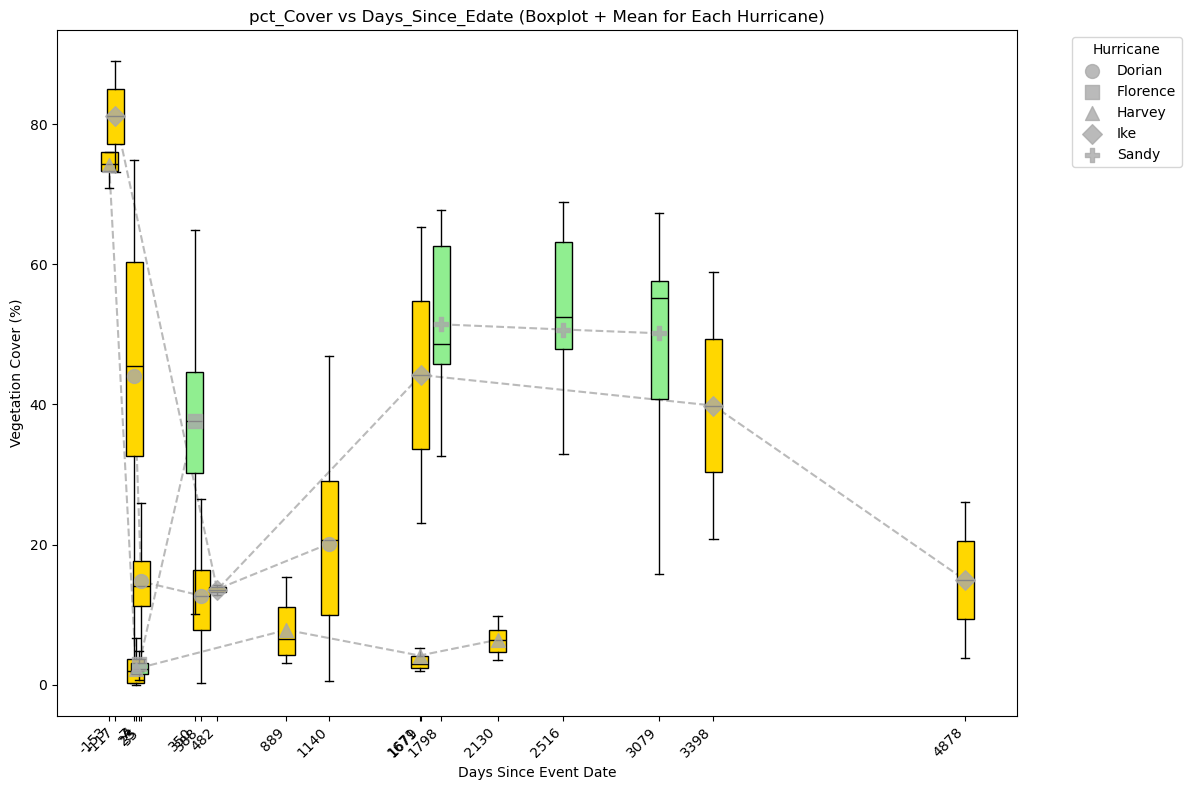

In [86]:

# Concatenate all DataFrames in df_dict into one DataFrame
combined_df = pd.concat([df.assign(Combo=df_name) for df_name, df in df_dict.items()])

# Ensure Days_Since_Edate is numeric
combined_df['Days_Since_Edate'] = pd.to_numeric(combined_df['Days_Since_Edate'], errors='coerce')

# Create a new figure for the combined boxplot
plt.figure(figsize=(12, 8))

# Get unique Days_Since_Edate values for the boxplot
unique_days = combined_df['Days_Since_Edate'].dropna().unique()

# Set unique colors for each Type
type_colors = {
    'Washout': 'gold',
    'Washover': 'lightgreen',
}

# Create a list to store the boxplot data and positions
box_data = []
positions = []

# Create boxplots for each unique Type
for t in combined_df['Type'].unique():
    for day in unique_days:
        # Get the data for the current day and type
        subset = combined_df[(combined_df['Days_Since_Edate'] == day) & (combined_df['Type'] == t)]
        if not subset.empty:
            box_data.append(subset['pct_Cover'])
            positions.append(day)  # Use the same day for the position
    # Draw the boxplot for the current type
    plt.boxplot(box_data, positions=positions, widths=100, patch_artist=True, 
                boxprops=dict(facecolor=type_colors.get(t, 'lightgray')), 
                medianprops=dict(color='black'), 
                showfliers=False)
    # Clear the box_data and positions for the next Type
    box_data = []
    positions = []

# Define markers for each unique hurricane
hurricane_markers = {'Dorian': 'o', 'Florence': 's', 'Harvey': '^', 'Ike': 'D', 'Sandy': 'P'}

# Loop through each hurricane to calculate the mean and plot it
for hurricane, marker in hurricane_markers.items():
    # Filter combined_df by the current hurricane
    hurricane_df = combined_df[combined_df['Hurricane'] == hurricane]

    # Calculate the mean pct_Cover for each unique value of Days_Since_Edate
    mean_df = hurricane_df.groupby('Days_Since_Edate', as_index=False)['pct_Cover'].mean()

    # Overplot the mean values with a unique marker for each hurricane
    plt.scatter(mean_df['Days_Since_Edate'], mean_df['pct_Cover'], 
                marker=marker, c='darkgray', label=hurricane, s=100, zorder = 10, alpha=.8)
    plt.plot(mean_df['Days_Since_Edate'], mean_df['pct_Cover'], 
                '--', c='darkgray', zorder = 0, alpha=.8)

#plt.xlim(-300,1200)
# Set plot title and labels
plt.title('pct_Cover vs Days_Since_Edate (Boxplot + Mean for Each Hurricane)')
plt.xlabel('Days Since Event Date')
plt.ylabel('Vegetation Cover (%)')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
plt.legend(title='Hurricane', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('scatterplot.svg', dpi=200, bbox_inches='tight')


In [87]:
# Save combined_df to a CSV file
combined_df.to_csv('combined_hurricane_data.csv', index=False)

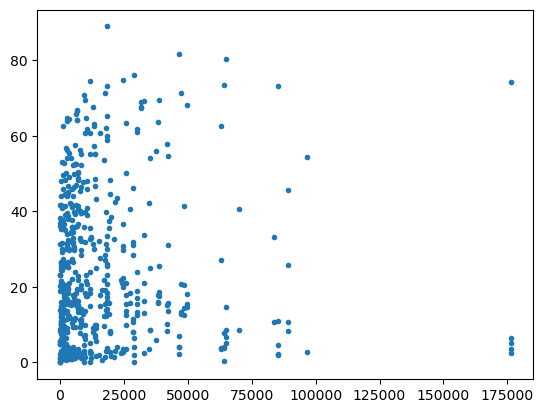

In [9]:
# No correlation between area and veg cover
plt.plot( df['Area_m2'], df['pct_Cover'], '.')